In [713]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from subprocess import check_output
%config InlineBackend.figure_format = 'retina'
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

#### Questions to answer:
1. On average, which type of grape is most expensive?
2. Which country produces the highest proportion of expensive wines?
3. Which characteristic is most important when classifying the type of grape?

In [714]:
# read in the first 150k rows of wine data
first_data_raw = pd.read_csv('winemag-data_first150k.csv')
first_data_raw.drop('Unnamed: 0', inplace=True, axis=1) # remove un-needed column

# load in second data set

second_data_raw = pd.read_csv('winemag-data-130k-v2.csv')
second_data_raw.drop(['Unnamed: 0', 'taster_name', 'taster_twitter_handle', 'title'], inplace=True, axis=1) # remove un-needed column
print('Raw DF shape: {}'.format(first_data_raw.shape))
display(first_data_raw.head())

Raw DF shape: (150930, 10)


,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [715]:
second_data_raw.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks


In [716]:
# create a concatenated dataframe with both datasets
data_raw = pd.concat([first_data_raw, second_data_raw], ignore_index=True)

In [717]:
# How many NaNs are in our dataset?
print('NaNs per column')
print(data_raw.isnull().sum().sort_values(ascending=False))

NaNs per column
region_2       169437
designation     83200
region_1        46307
price           22691
province           68
country            68
variety             1
winery              0
points              0
description         0
dtype: int64


In [718]:
# Looks like Region 2 has by far the most NaNs. 
# Designation won't be used in our analysis as it includes natural language
data_raw.drop(['designation', 'region_2' ], inplace=True, axis=1) # drop two highest NaN columns

In [719]:
# Take another look at the NaNs
print('Shape with two columns removed: {}'.format(data_raw.shape))
print('NaNs per column')
NaNs = data_raw.isnull().sum().sort_values(ascending=False)
print(NaNs)

Shape with two columns removed: (280901, 8)
NaNs per column
region_1       46307
price          22691
province          68
country           68
variety            1
winery             0
points             0
description        0
dtype: int64


In [720]:
# How much of the columns are missing?
for col in NaNs.index[:2]:
    print('{:.2%} of values missing for'.format(NaNs[col]/data_raw.shape[0]), col)

16.49% of values missing for region_1
8.08% of values missing for price


### These proportions are not too drastic, we will impute the mean of the price after the data has been divided into expensive/inexpensive segments. We will not use the region in our models but will keep it in our data for reference later if needed

In [721]:
# are there any duplicate rows? 
print('{} duplicate rows'.format(data_raw.duplicated().sum()))

111125 duplicate rows


In [722]:
# drop duplicate rows
data = data_raw.drop_duplicates()

In [723]:
print('Shape with duplicates removed: {}'.format(data.shape))

Shape with duplicates removed: (169776, 8)


In [724]:
print('Removed {:,} duplicates from original data'.format(data_raw.shape[0] - data.shape[0]))

Removed 111,125 duplicates from original data


In [725]:
# create subset of data with wines priced over a certain threshold
expensive_price_threshold = 75
expensive = data[data['price'] > expensive_price_threshold]

# sample of the dataframe
display(expensive.sample(5))

,country,description,points,price,province,region_1,variety,winery
10874,Portugal,"Old gold in color, this is a really mature Col...",95,320.0,Port,NaN,Port,Cálem
34940,France,A ripe year like 2009 is kind to the Cabernet ...,96,280.0,Bordeaux,Saint-Émilion,Bordeaux-style Red Blend,Château Figeac
194107,Italy,"You'll find aromas of toasted oak, underbrush,...",90,210.0,Tuscany,Chianti Classico,Red Blend,Castello di Ama
64117,Argentina,"The nose is dusty and inviting, with notes of ...",93,150.0,Mendoza Province,Luján de Cuyo,Bordeaux-style Red Blend,Luigi Bosca
69860,Chile,Montes Folly is the benchmark by which all oth...,93,95.0,Santa Cruz,NaN,Syrah,Montes


In [726]:
# how many NaNs in the expensive dataset?
expensive_NaNs = expensive.isnull().sum().sort_values(ascending=False)
print('Shape of expensive data: {}'.format(expensive.shape))
print(expensive_NaNs)

Shape of expensive data: (9616, 8)
region_1       874
winery           0
variety          0
province         0
price            0
points           0
description      0
country          0
dtype: int64


### Great! By happenstance, none of the wines with a price higher than USD 50 have any missing price data points

In [727]:
# create a DF with the value counts of each grape variety
variety_counts = expensive['variety'].value_counts().to_frame()
print('10 highest represented grape varieties with price more than $50')
display(variety_counts[:10])

10 highest represented grape varieties with price more than $50


,variety
Cabernet Sauvignon,1938
Pinot Noir,1180
Bordeaux-style Red Blend,771
Chardonnay,709
Red Blend,692
Nebbiolo,657
Champagne Blend,424
Sangiovese,355
Syrah,299
Riesling,257


In [728]:
# let's remind ourselves what the data looks like
display(expensive.sample(10))

,country,description,points,price,province,region_1,variety,winery
104197,US,"A bold, muscular, striking wine with nerves of...",98,135.0,Washington,Columbia Valley (WA),Cabernet Sauvignon,Quilceda Creek
265930,Spain,This tawny tinted Palo Cortado will make a She...,94,170.0,Andalucia,Jerez,Sherry,Bodegas Hidalgo
144904,Italy,This Barbaresco is big and maybe a touch “inte...,91,105.0,Piedmont,Barbaresco,Nebbiolo,Pio Cesare
151949,US,"Estate bottled, this assemblage of 77% Caberne...",88,125.0,California,Napa Valley,Bordeaux-style Red Blend,Spring Mountain Vineyard
185577,Spain,"Gorgeous from head to toe, this opens with ced...",94,98.0,Catalonia,Priorat,Red Blend,Mas d'en Gil
145422,Italy,This curiosity comes from a single hectare of ...,89,217.0,Southern Italy,Pompeiano,Red Blend,Mastroberardino
196412,US,"This structured, generously full-bodied wine o...",88,125.0,California,Howell Mountain,Cabernet Sauvignon,Kristodd
97755,France,"Heavy and glowering, this wine is powered with...",88,129.0,Burgundy,Corton-Charlemagne,Chardonnay,Labouré-Roi
132495,France,"This is ripe, open wine with layers of Pinot N...",89,85.0,Champagne,Champagne,Champagne Blend,Boizel
54184,US,"Classic structured, firm and soft at the same ...",95,105.0,California,Napa Valley,Cabernet Sauvignon,Beaulieu Vineyard


In [729]:
# calculate the standard deviation of each grape variety's price
variety_stds = expensive.groupby('variety').std().dropna()

# remove records where only one variety is present
variety_stds.columns = ['points_std', 'price_std']

# calculate mean of each grape variety
variety_means = expensive.groupby('variety').mean().dropna()

# rename columns
variety_means.columns = ['avg_points', 'avg_price']

# calculate median of each grape variety
variety_medians = expensive.groupby('variety').median().dropna()

# rename columns
variety_medians.columns = ['med_points', 'med_price']

# rename value_counts df column for merge
variety_counts.columns = ['variety_count']

# inner join on grape variety index
variety_stats = variety_stds.join(
    [variety_means, variety_medians, variety_counts], how='inner').sort_values(
        by='med_price', ascending=False)

In [730]:
variety_counts.shape

(168, 1)

In [731]:
variety_stats.shape

(121, 7)

75 grape varieties only occured once in the data, so they are not included in the stats DF

#### 1. Out of our expensive subset, which grape variety tends to have the most expensive price point?

In [732]:
print('EXPENSIVE WINE DATA GROUPED BY GRAPE VARIETY')
display(variety_stats.head(10)) # DF is sorted by median price

EXPENSIVE WINE DATA GROUPED BY GRAPE VARIETY


,points_std,price_std,avg_points,avg_price,med_points,med_price,variety_count
Furmint,1.414214,313.955411,95.000000,542.000000,95.0,542.0,2
Tempranillo-Cabernet Sauvignon,1.707825,271.584855,91.250000,317.500000,91.5,295.0,4
Muscadel,2.828427,113.137085,95.000000,220.000000,95.0,220.0,2
Muscadelle,2.629956,108.742816,96.250000,232.500000,96.0,220.0,4
Bual,2.121320,25.455844,96.500000,212.000000,96.5,212.0,2
Silvaner,3.130495,74.596917,90.600000,184.200000,90.0,177.0,5
Tinta de Toro,1.947730,62.191886,93.642857,159.857143,94.0,159.0,28
Pedro Ximénez,2.000000,72.762170,93.000000,175.666667,93.0,149.0,3
Malbec-Cabernet,0.000000,24.748737,93.000000,147.500000,93.0,147.5,2
Petite Verdot,3.000000,39.051248,91.000000,125.000000,91.0,145.0,3


It looks like the most expensive wines aren't very well-represented, which makes sense. The top five wines above, represented by median price, don't necessarily tell a lot as their mean is very close to the median, if not the same. We can see the `Tinta de Toro` variety has a lot more data points, and are consistently priced highly. I would conclude that this variety of grape reliably produces wines that are on the more expensive side. 

In [733]:
# Let's do the same analysis, but for country

# create a DF with the value counts of each grape's country
country_counts = expensive['country'].value_counts().to_frame()

# calculate the standard deviation of each grape country's price
country_stds = expensive.groupby('country').std().dropna()

# remove records where only one vcountry is present
country_stds.columns = ['points_std', 'price_std']

# calculate mean of each grape country
country_means = expensive.groupby('country').mean().dropna()

# rename columns
country_means.columns = ['avg_points', 'avg_price']

# calculate median of each grape country
country_medians = expensive.groupby('country').median().dropna()

# rename columns
country_medians.columns = ['med_points', 'med_price']

# rename value_counts df column for merge
country_counts.columns = ['variety_count']

# inner join on grape variety index
country_stats = country_stds.join(
    [country_means, country_medians, country_counts], how='inner').sort_values(
        by='variety_count', ascending=False)

#### 2. Which country produces the highest proportion of expensive wines?

In [734]:
print('EXPENSIVE WINE DATA GROUPED BY COUNTRY')
display(country_stats.head(10)) # DF is sorted by descending variety_count

EXPENSIVE WINE DATA GROUPED BY COUNTRY


,points_std,price_std,avg_points,avg_price,med_points,med_price,variety_count
US,2.908787,57.650411,91.997684,112.917776,92.0,95.0,3454
France,2.442166,178.279933,92.712505,163.881822,93.0,111.0,2327
Italy,2.713761,69.858724,91.851515,120.430808,92.0,98.0,1980
Spain,2.898463,80.221118,91.628205,135.948718,92.0,110.0,468
Australia,2.744597,113.223181,92.587629,140.601375,93.0,100.0,291
Portugal,3.110157,133.111885,92.803279,143.778689,93.0,100.0,244
Germany,2.909501,142.763957,92.394619,176.156951,93.0,111.0,223
Argentina,1.927202,33.078351,91.824390,112.936585,92.0,100.0,205
Chile,2.018330,62.642102,91.248227,115.900709,92.0,92.0,141
Austria,2.141623,97.017119,93.589286,104.553571,94.0,90.0,112


Interestingly enough, I thought France would be the highest contributor to the expensive wine market, but the US almost doubles France's representation in the dataset. Compared to the US and Italy, France's `avg_price` is much further away than its respective median. 

France's price standard deviation is 3.5x that of the US, meaning that France produces a much larger variety in terms of price. (This affirms my preconceptions)

We never looked at the distribution of our data. Below is a plot that shows the distribution of price vs points, observing the trend between the two. On each axis you can see the distribution of each individual data series. The right hand distribution (price) shows that there is a large spike in the lower side of the price range, which makes sense. The points distribution seems to follow a normal distribution around a central mean. There is also a linear regression line plotted over the points.

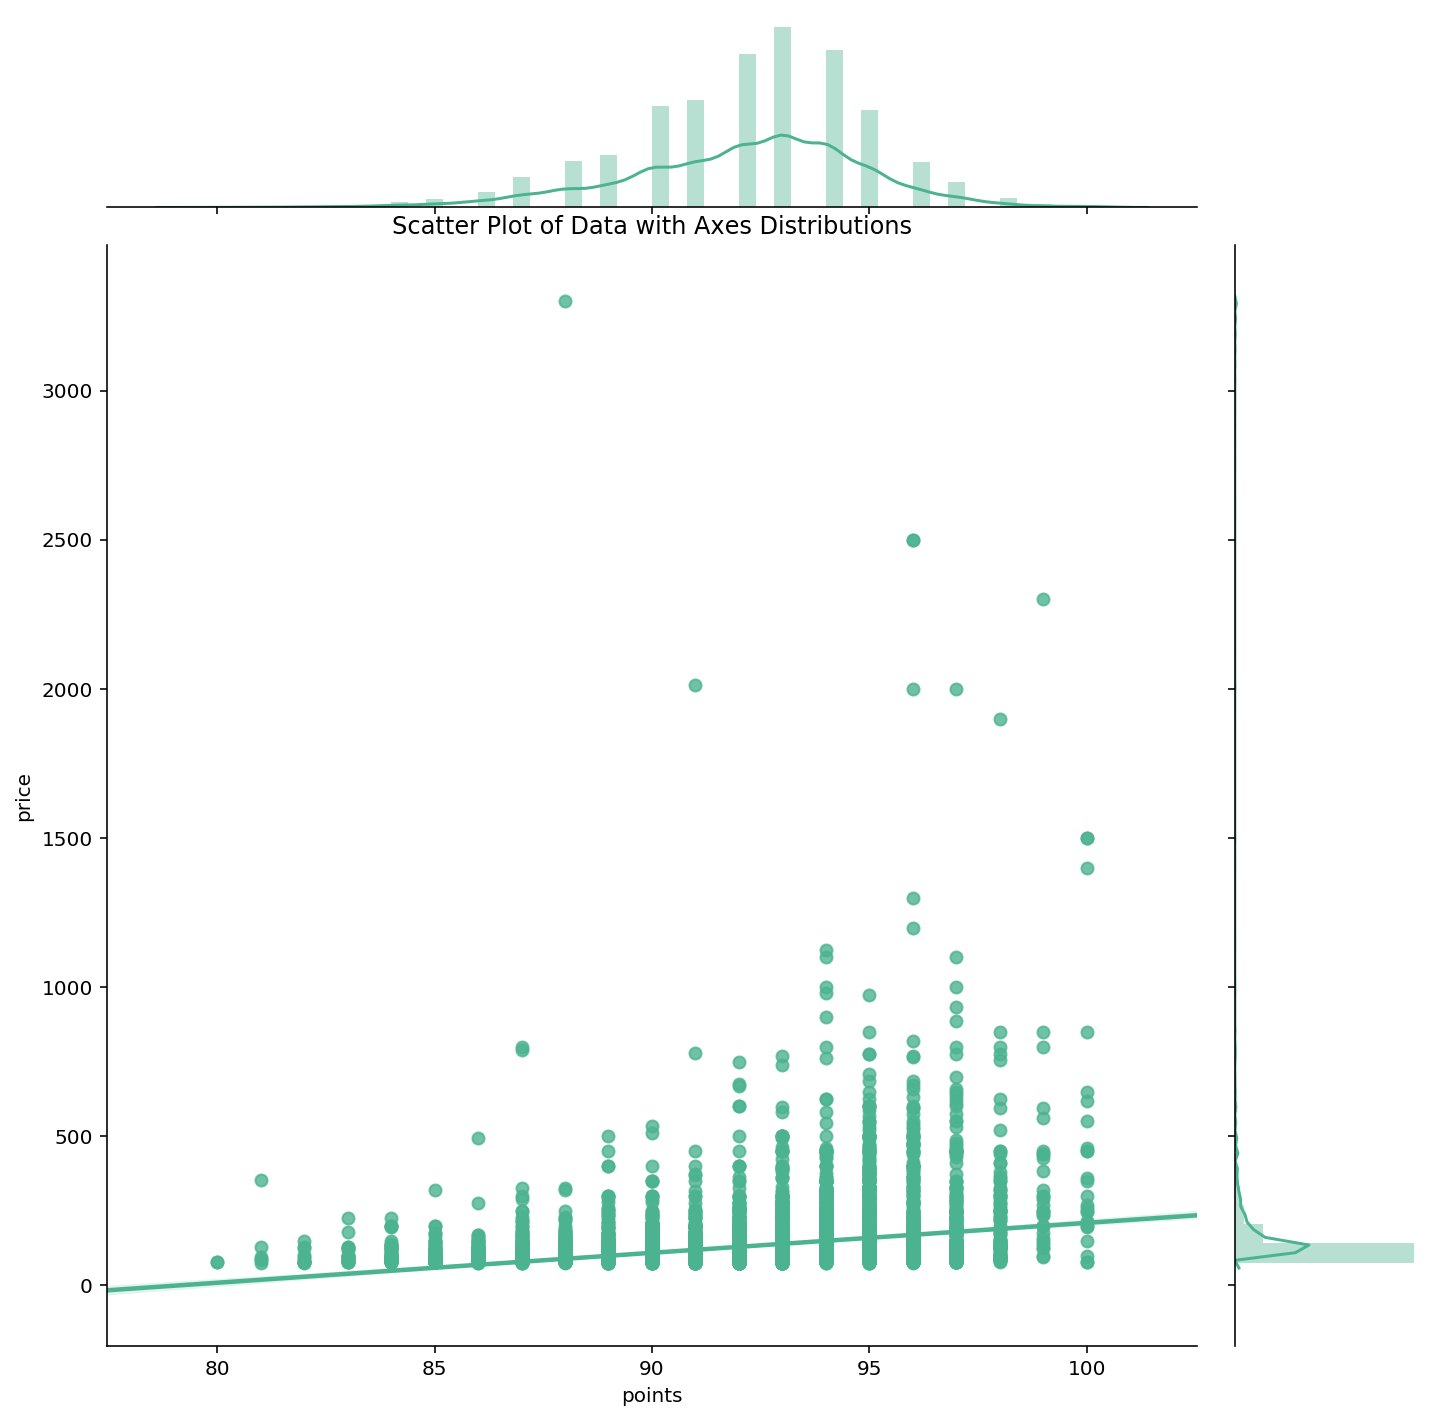

In [735]:
# seaborn jointplot showing multiple distributions

sns.jointplot(
    x='points',
    y='price',
    data=expensive,
    kind='reg',
    color="#4CB391",
    height=10)
plt.title('Scatter Plot of Data with Axes Distributions');

Looking at these data we can see a trend between price and points. We can try to build a classifier to classify the grape variety based on all of the other features in the dataset.

In [736]:
# select only the columns that we want to create dummy variables with
x_split = expensive[['country', 'points', 'price', 'province', 'region_1', 'winery']]

# target value
y_split = expensive['variety']

In [737]:
# create dummy variables (1s and 0s for the categorical/text features)

x_split = pd.get_dummies(
    x_split, columns=['country', 'province', 'region_1', 'winery'])
y_split = pd.get_dummies(y_split, columns=['variety'])

In [738]:
# Here we see there are a LOT of columns, each one representing a categorical variable
print('X FEATURES')
display(x_split.sample(5))
print('TARGET LABEL')
display(y_split.sample(5))

X FEATURES


,points,price,country_Argentina,country_Australia,country_Austria,country_Bulgaria,country_Canada,country_Chile,country_England,country_France,...,winery_Z. Alexander Brown,winery_ZD,winery_Zenato,winery_Ziata,winery_Zorzal,winery_Zuccardi,winery_Zymè,winery_iNapa Wine,winery_Ànima Negra,winery_Ökonomierat Rebholz
148179,94,125.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223681,94,130.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
115470,93,85.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
28295,90,80.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
197799,94,120.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


TARGET LABEL


,Aglianico,Albariño,Alicante Bouschet,Alsace white blend,Austrian Red Blend,Austrian white blend,Baga,Barbera,Blaufränkisch,Bobal,...,Traminer,Verdelho,Vermentino,Vidal Blanc,Viognier,Vitovska,Viura,Welschriesling,White Blend,Zinfandel
267081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [739]:
x_split = pd.DataFrame(StandardScaler().fit_transform(x_split),columns=x_split.columns)

In [740]:
x_split.sample(10)

,points,price,country_Argentina,country_Australia,country_Austria,country_Bulgaria,country_Canada,country_Chile,country_England,country_France,...,winery_Z. Alexander Brown,winery_ZD,winery_Zenato,winery_Ziata,winery_Zorzal,winery_Zuccardi,winery_Zymè,winery_iNapa Wine,winery_Ànima Negra,winery_Ökonomierat Rebholz
6143,1.034733,-0.413945,-0.147591,-0.176653,-0.108556,-0.010198,-0.044495,-0.121989,-0.02699,-0.565021,...,-0.010198,-0.02699,-0.022809,-0.014423,-0.010198,-0.030607,-0.0204,-0.010198,-0.010198,-0.010198
4430,-1.875473,-0.404917,-0.147591,-0.176653,-0.108556,-0.010198,-0.044495,-0.121989,-0.02699,-0.565021,...,-0.010198,-0.02699,-0.022809,-0.014423,-0.010198,-0.030607,-0.0204,-0.010198,-0.010198,-0.010198
7627,0.307182,-0.007701,-0.147591,-0.176653,-0.108556,-0.010198,-0.044495,-0.121989,-0.02699,-0.565021,...,-0.010198,-0.02699,-0.022809,-0.014423,-0.010198,-0.030607,-0.0204,-0.010198,-0.010198,-0.010198
7418,-0.056594,-0.188254,6.775494,-0.176653,-0.108556,-0.010198,-0.044495,-0.121989,-0.02699,-0.565021,...,-0.010198,-0.02699,-0.022809,-0.014423,-0.010198,-0.030607,-0.0204,-0.010198,-0.010198,-0.010198
4544,1.034733,1.707551,-0.147591,-0.176653,-0.108556,-0.010198,-0.044495,-0.121989,-0.02699,1.769847,...,-0.010198,-0.02699,-0.022809,-0.014423,-0.010198,-0.030607,-0.0204,-0.010198,-0.010198,-0.010198
7162,-0.784146,-0.386862,-0.147591,-0.176653,-0.108556,-0.010198,-0.044495,-0.121989,-0.02699,-0.565021,...,-0.010198,-0.02699,-0.022809,-0.014423,-0.010198,-0.030607,-0.0204,-0.010198,-0.010198,-0.010198
7757,1.034733,-0.323669,-0.147591,-0.176653,-0.108556,-0.010198,-0.044495,-0.121989,-0.02699,-0.565021,...,-0.010198,-0.02699,-0.022809,-0.014423,-0.010198,-0.030607,-0.0204,-0.010198,-0.010198,-0.010198
2243,0.670958,-0.413945,-0.147591,-0.176653,-0.108556,-0.010198,-0.044495,-0.121989,-0.02699,-0.565021,...,-0.010198,-0.02699,-0.022809,-0.014423,-0.010198,-0.030607,-0.0204,-0.010198,-0.010198,-0.010198
1688,0.670958,-0.459083,-0.147591,-0.176653,-0.108556,-0.010198,-0.044495,-0.121989,-0.02699,-0.565021,...,-0.010198,-0.02699,-0.022809,-0.014423,-0.010198,-0.030607,-0.0204,-0.010198,-0.010198,-0.010198
1163,0.670958,-0.287558,-0.147591,-0.176653,-0.108556,-0.010198,-0.044495,-0.121989,-0.02699,-0.565021,...,-0.010198,-0.02699,-0.022809,-0.014423,-0.010198,-0.030607,-0.0204,-0.010198,-0.010198,-0.010198


In [741]:
# split our data into training and testing data sets

X_train, X_test, y_train, y_test = train_test_split(
    x_split, y_split, random_state=1, test_size=0.2)

In [742]:
# impute the means for all missing values in the dataset
X_train = pd.DataFrame(
    Imputer().fit_transform(X_train), columns=x_split.columns)
X_test = pd.DataFrame(
    Imputer().fit_transform(X_test), columns=x_split.columns)

In [743]:
print('NUM OF NaNs IN IMPUTED DATA')
X_train.isnull().sum().sum()

NUM OF NaNs IN IMPUTED DATA


0

In [744]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [745]:
# INSTANTIATE A RANDOM FOREST CLASSIFIER
clf = RandomForestClassifier()
preds = clf.fit(X_train, y_train).predict(X_test)
print('Accuracy of un-optimised model: {:2%}'.format(
    accuracy_score(y_test, preds)))

Accuracy of un-optimised model: 72.037422%


In [746]:
# GRID SEARCH CV TO OPTIMISE

param_grid = {
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [50, 100, 200],
    'n_jobs': [-1]
}

scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, param_grid, scoring=scorer, cv=10)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_preds = best_clf.predict(X_test)

In [747]:
print('Accuracy of optimised model: {:2%}'.format(accuracy_score(y_test, best_preds)))

Accuracy of optimised model: 74.792100%


In [748]:
# OPTIMISED PARAMETERS
best_clf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [749]:
# CREATE DICTIONARY OF FEATURE IMPORTANCES AND SORT THEM DESC

feats = {}
for feature, importance in zip(x_split.columns, best_clf.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'}).sort_values(by='Gini-importance', ascending=False)

In [750]:
importances.head()

,Gini-importance
price,0.090835
points,0.077116
province_California,0.028291
province_Piedmont,0.028050
country_US,0.024857


In [ ]:
importances[:10].plot(kind='bar')

In [ ]:
# CASE BY CASE TESTS, PRINTS EVERY 25TH ITERATION
results = 0
print_every = 25
for i in range(len(X_test)):
    pred = best_clf.predict(X_test.iloc[[i]])
    res = pd.DataFrame(pred, columns=y_test.columns)
    if i % print_every == 0 and i != 0:
        print('Running Accuracy: {:.2%}'.format((results / i)))
        print('{} vs {}'.format(
            res.idxmax(axis=1).values, y_test.iloc[[i]].idxmax(axis=1).values))
    if res.idxmax(axis=1).values == y_test.iloc[[i]].idxmax(axis=1).values:
        results += 1
    else:
        continue
print('Final accuracy: {:.2%}'.format(results/len(X_test)))

Running Accuracy: 76.00%
['Riesling'] vs ['Riesling']
Running Accuracy: 78.00%
['Bordeaux-style Red Blend'] vs ['Cabernet Sauvignon']
Running Accuracy: 70.67%
['Cabernet Sauvignon'] vs ['Cabernet Sauvignon']
Running Accuracy: 72.00%
['Malbec'] vs ['Malbec']
Running Accuracy: 72.00%
['Pinot Noir'] vs ['Pinot Noir']
Running Accuracy: 73.33%
['Cabernet Sauvignon'] vs ['Cabernet Sauvignon']
Running Accuracy: 73.71%
['Cabernet Sauvignon'] vs ['Cabernet Sauvignon']
Running Accuracy: 71.50%
['Cabernet Sauvignon'] vs ['Cabernet Sauvignon']
Running Accuracy: 71.56%
['Aglianico'] vs ['Red Blend']
Running Accuracy: 72.40%
['Nebbiolo'] vs ['Nebbiolo']
Running Accuracy: 72.36%
['Cabernet Sauvignon'] vs ['Cabernet Sauvignon']
Running Accuracy: 73.67%
['Red Blend'] vs ['Cabernet Sauvignon']
Running Accuracy: 72.92%
['Shiraz'] vs ['Cabernet Sauvignon']
Running Accuracy: 72.57%
['Nebbiolo'] vs ['Nebbiolo']
Running Accuracy: 73.60%
['Riesling'] vs ['Riesling']
Running Accuracy: 74.00%
['Port'] vs ['Port